In [7]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images #type:ignore
from tensorflow.keras.models import Sequential  # For building the model #type:ignore
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers #type:ignore
from tensorflow.keras.optimizers import Adam  # For optimizer #type:ignore
from tensorflow.keras.applications import VGG16  # For using VGG16 model #type:ignore 
from sklearn.utils import shuffle  # For shuffling the data #type:ignore

In [5]:
import os
from collections import defaultdict

# Base directory for dataset (adjust path if needed)
base_dir = '../datasets/MRI Images'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Function to count images per class in a directory
def count_images_per_class(directory):
    class_counts = defaultdict(int)
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            class_counts[label] = len([
                f for f in os.listdir(label_dir)
                if os.path.isfile(os.path.join(label_dir, f))
            ])
    return class_counts

# Get image counts
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Print training set stats
print('Training set:')
for label, count in train_counts.items():
    print(f'{label}: {count} images')

# Print testing set stats
print('\nTesting set:')
for label, count in test_counts.items():
    print(f'{label}: {count} images')


Training set:
pituitary: 1457 images
notumor: 1595 images
glioma: 1321 images
meningioma: 1339 images

Testing set:
pituitary: 300 images
notumor: 405 images
glioma: 300 images
meningioma: 306 images


In [ ]:
# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels) #type:ignore

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels) #type:ignore

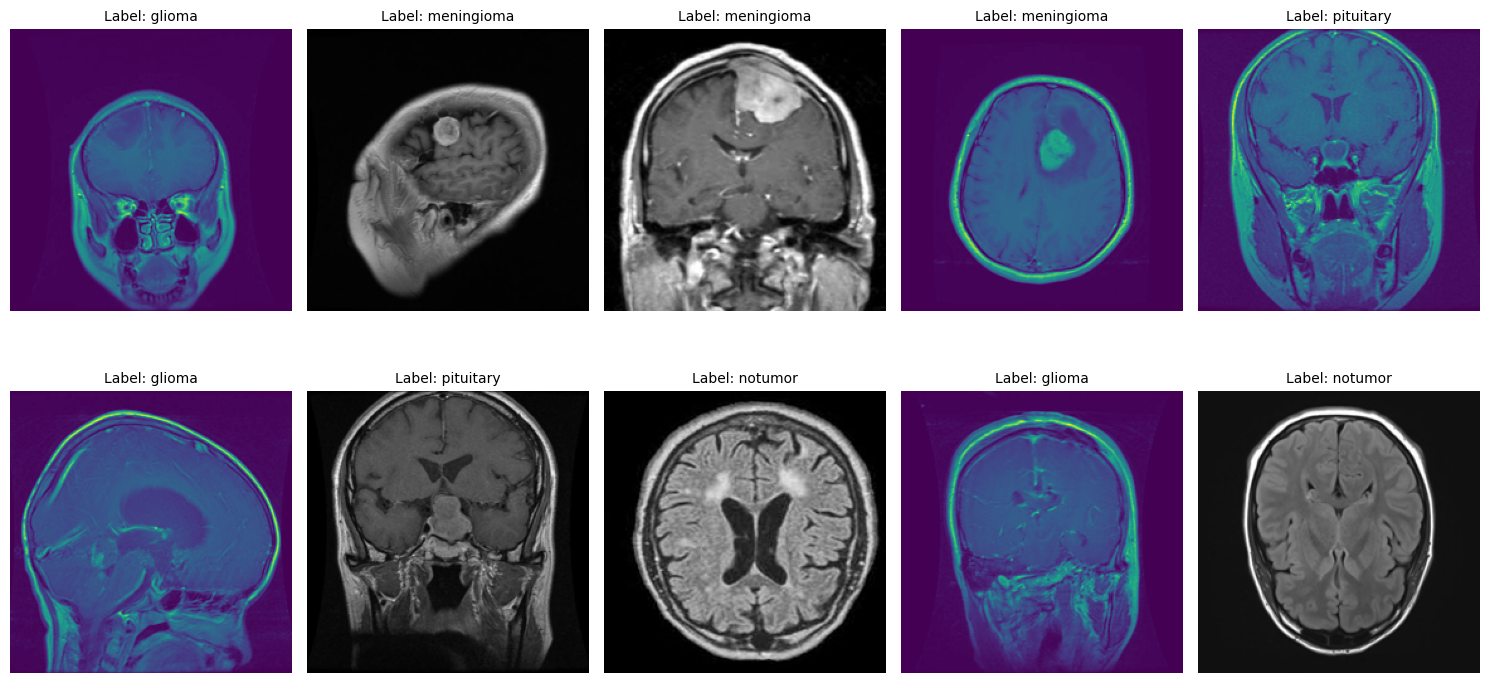

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) #type:ignore
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [11]:
len(os.listdir(train_dir))

4

In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)

# Import VGG16 here to ensure it's available
from tensorflow.keras.applications import VGG16 #type:ignore

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-7].trainable = True # Unfreeze 7th last layer
base_model.layers[-6].trainable = True # Unfreeze 6th last layer
base_model.layers[-5].trainable = True # Unfreeze 5th last layer
base_model.layers[-4].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-2].trainable = True


# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5 # Increased epochs to 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 [==============================] - 9s 0us/step


Epoch 1/5
285/285 [==============================] - 444s 2s/step - loss: 0.4265 - sparse_categorical_accuracy: 0.8402
Epoch 2/5
285/285 [==============================] - 479s 2s/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9169
Epoch 3/5
285/285 [==============================] - 540s 2s/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9512
Epoch 4/5
285/285 [==============================] - 432s 2s/step - loss: 0.0918 - sparse_categorical_accuracy: 0.9678
Epoch 5/5
285/285 [==============================] - 483s 2s/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9721


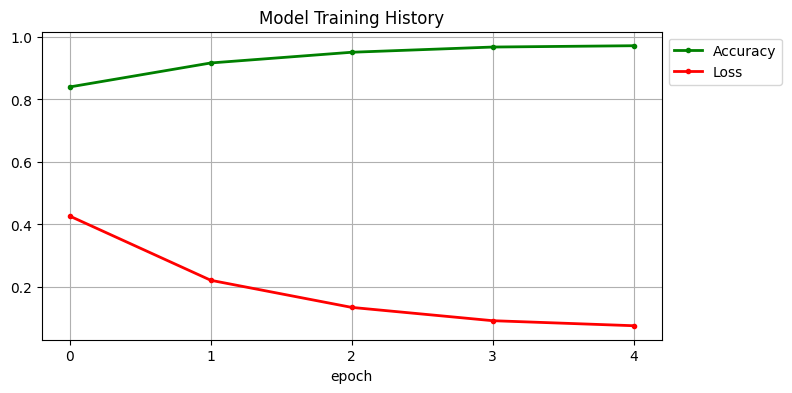

In [14]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [17]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 [==============================] - 52s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       300
           1       1.00      0.99      0.99       405
           2       0.98      0.94      0.96       300
           3       0.93      0.95      0.94       306

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



Confusion Matrix:
[[294   0   0   6]
 [  1 401   2   1]
 [  3   0 283  14]
 [  8   1   5 292]]


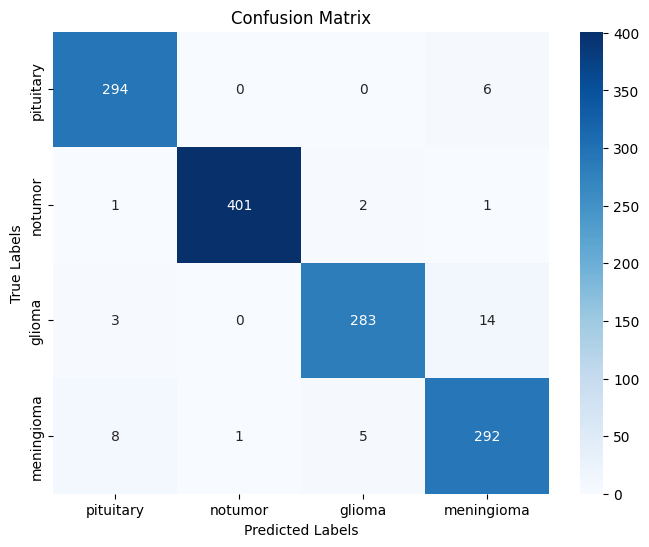

In [18]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

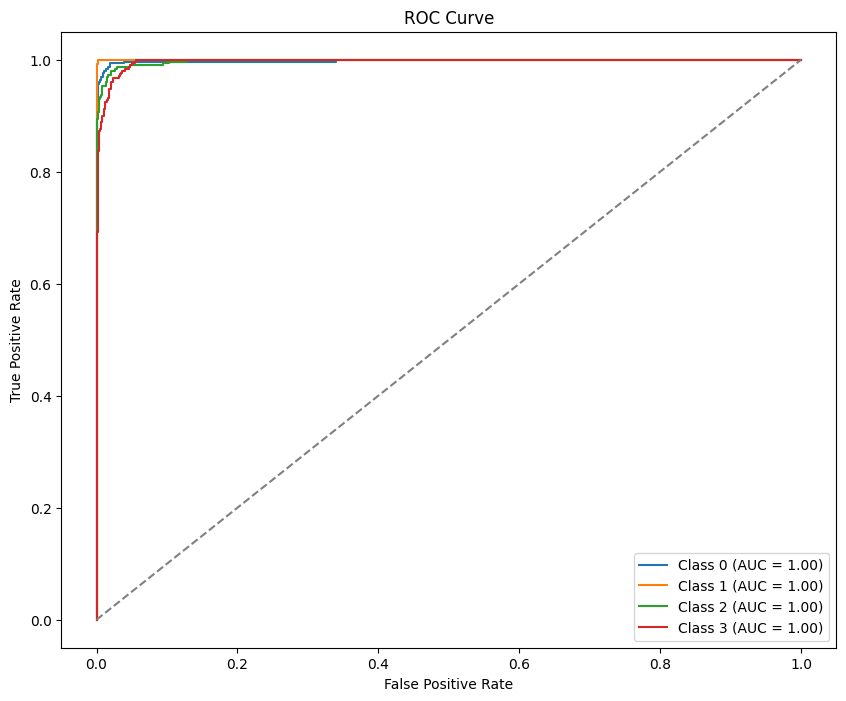

In [19]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [33]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'notumor', 'glioma', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 65ms/step


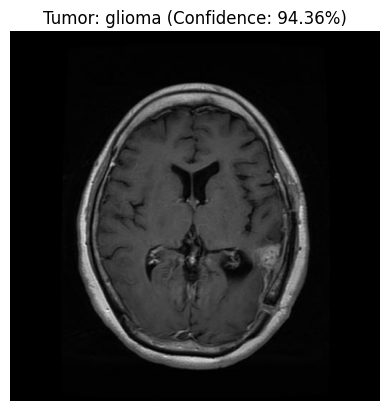

In [36]:
image_path = '/Users/b.anasurya/Desktop/Machine_Learning/Brain_Tumor/Datasets/MRI Images/Testing/glioma/Te-gl_0019.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [30]:
for path, label in zip(train_paths[:10], train_labels[:10]):
    print(path, label)

../datasets/MRI Images/Training/notumor/Tr-no_0544.jpg notumor
../datasets/MRI Images/Training/glioma/Tr-gl_0849.jpg glioma
../datasets/MRI Images/Training/pituitary/Tr-pi_0519.jpg pituitary
../datasets/MRI Images/Training/pituitary/Tr-pi_0339.jpg pituitary
../datasets/MRI Images/Training/glioma/Tr-gl_1044.jpg glioma
../datasets/MRI Images/Training/meningioma/Tr-me_1261.jpg meningioma
../datasets/MRI Images/Training/notumor/Tr-no_0727.jpg notumor
../datasets/MRI Images/Training/pituitary/Tr-pi_1170.jpg pituitary
../datasets/MRI Images/Training/pituitary/Tr-pi_1314.jpg pituitary
../datasets/MRI Images/Training/pituitary/Tr-pi_0938.jpg pituitary


In [31]:
# If you use one-hot encoding:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
pred = model.predict(img)
predicted_class = class_names[np.argmax(pred)]
print("Predicted:", predicted_class)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>